In [49]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn
seaborn.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
seaborn.mpl.rcParams['savefig.dpi'] = 90
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

In [50]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)

        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

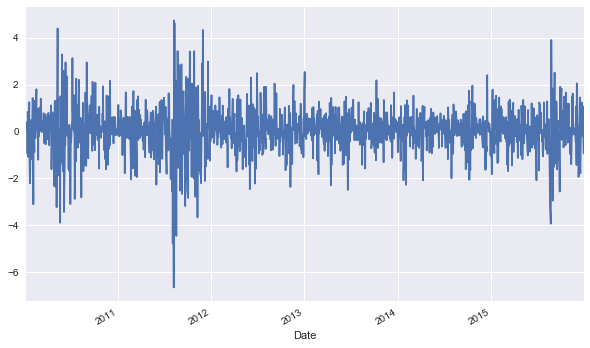

In [51]:
import datetime as dt
import pandas_datareader.data as web
st = dt.datetime(2010,1,1)
en = dt.datetime(2016,1,1)
#  Get data for SnP 500 

data = web.get_data_yahoo('^GSPC', start=st, end=en)
returns = 100 * data['Adj Close'].pct_change().dropna()
figure = returns.plot()

GARCH (with a Constant Mean)
The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

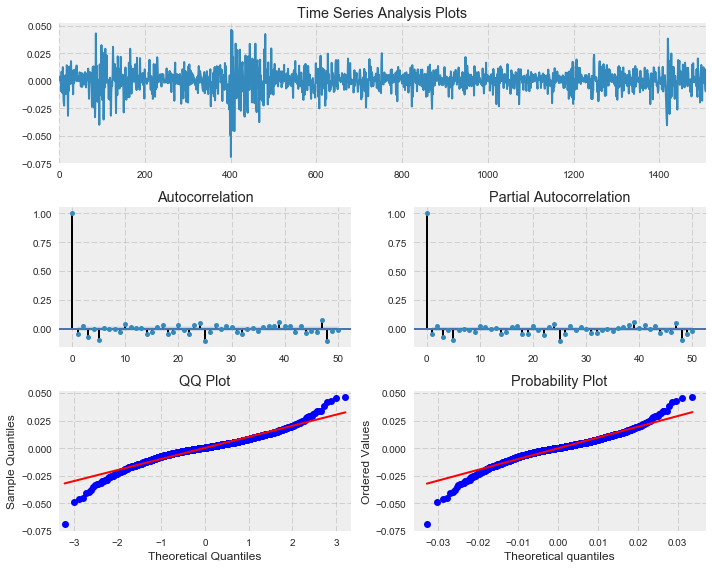

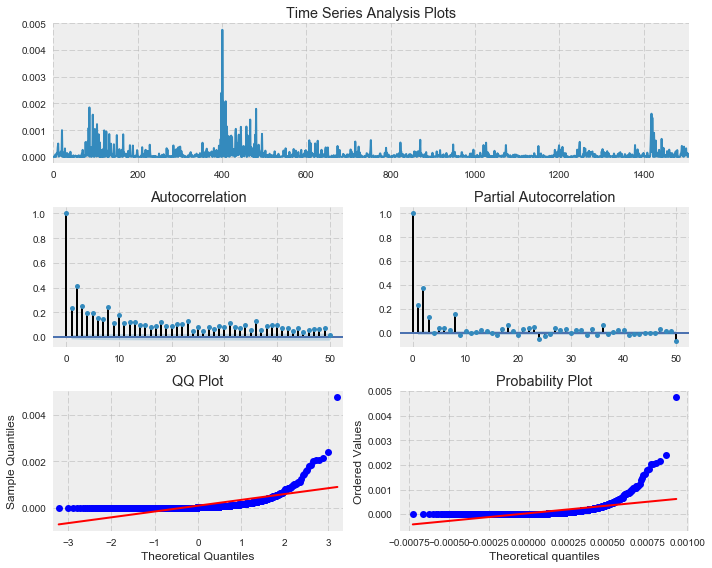

In [52]:
import numpy as np
log_returns = np.diff(np.log(data['Adj Close']))
tsplot(log_returns, 50)
tsplot(np.square(log_returns), 50)

In [53]:
am = arch_model(log_returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     66,   Neg. LLF: -5001.46489578
Iteration:     10,   Func. Count:    140,   Neg. LLF: -5001.46646134
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -5001.46646314
            Iterations: 14
            Function evaluations: 140
            Gradient evaluations: 10


/usr/local/lib/python2.7/site-packages/arch/univariate/base.py:517: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                5001.47
Distribution:                  Normal   AIC:                          -9994.93
Method:            Maximum Likelihood   BIC:                          -9973.66
                                        No. Observations:                 1509
Date:                Fri, Mar 31 2017   Df Residuals:                     1505
Time:                        18:54:30   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.5513e-04  2.032e-06    322.366      0.000 [6.

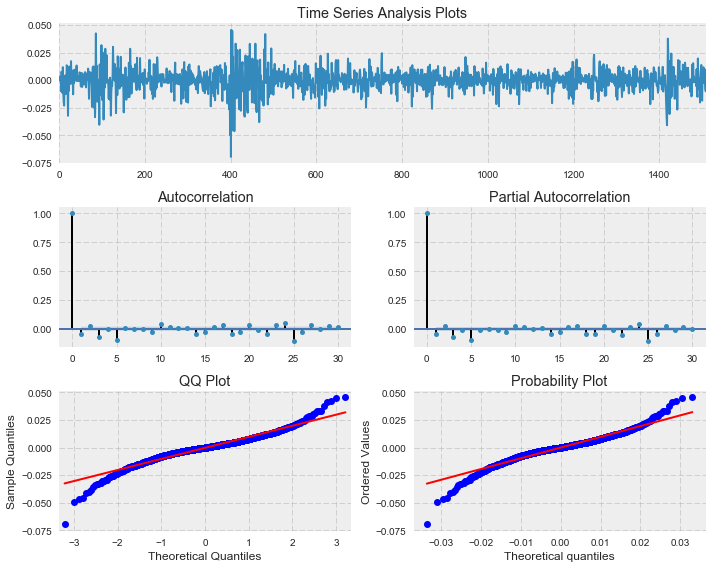

In [54]:
tsplot(res.resid, 30)

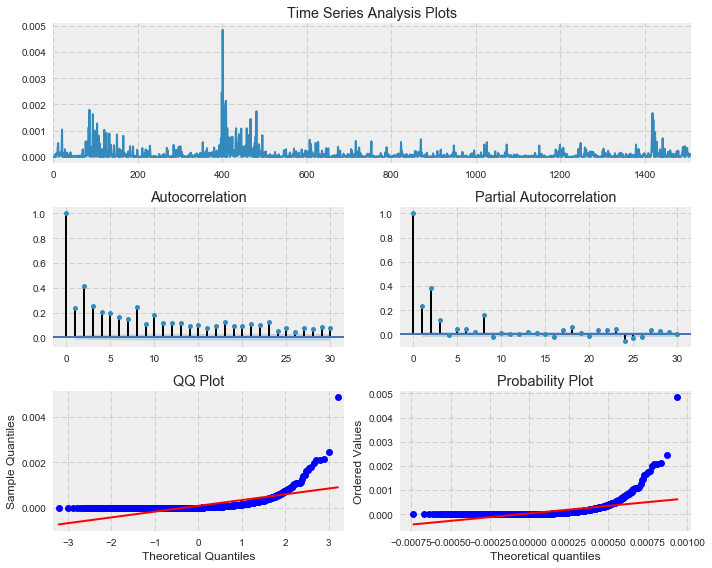

In [55]:
tsplot(np.square(res.resid), 30)

In [56]:

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = log_returns
res_tup = _get_best_model(TS)

aic: -9611.23518 | order: (3, 0, 3)


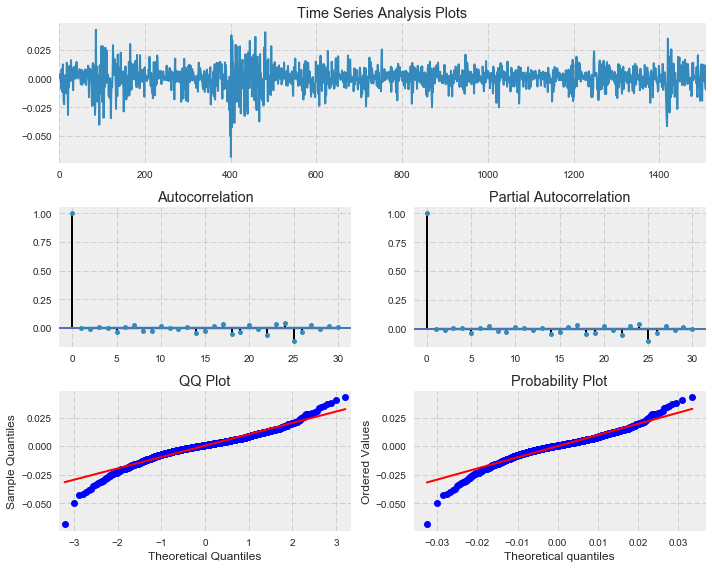

In [57]:
tsplot(res_tup[2].resid, 30)

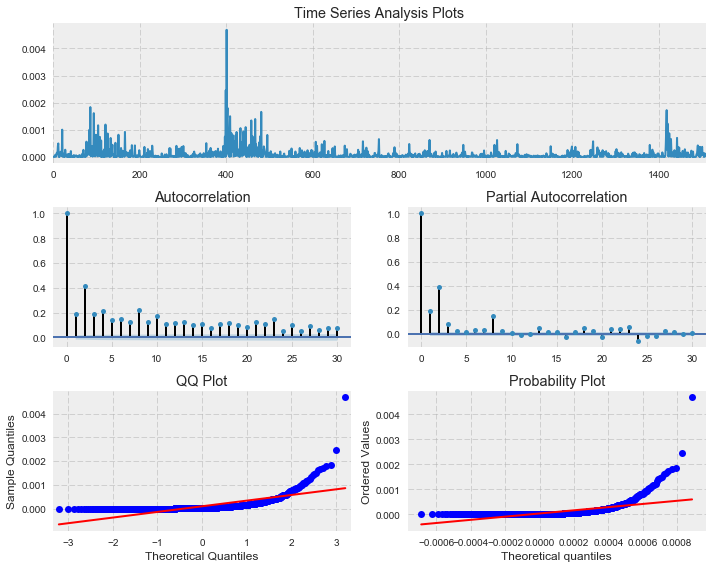

In [58]:
tsplot(np.square(res_tup[2].resid), 30)

Looks like there is still some autocorrelation 
Lets try and apply GARCH model now with the same (3,0,3)

In [59]:
p_ = 3
o_ = 0
q_ = 3

# Using student T distribution usually provides better fit
# It captures the fat tail observation isn financial market returns
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

/usr/local/lib/python2.7/site-packages/arch/univariate/base.py:517: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -3.508
Mean Model:                   Constant Mean   Adj. R-squared:                 -3.508
Vol Model:                            GARCH   Log-Likelihood:                3267.29
Distribution:      Standardized Student's t   AIC:                          -6516.58
Method:                  Maximum Likelihood   BIC:                          -6468.71
                                              No. Observations:                 1509
Date:                      Fri, Mar 31 2017   Df Residuals:                     1500
Time:                              18:55:11   Df Model:                            9
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

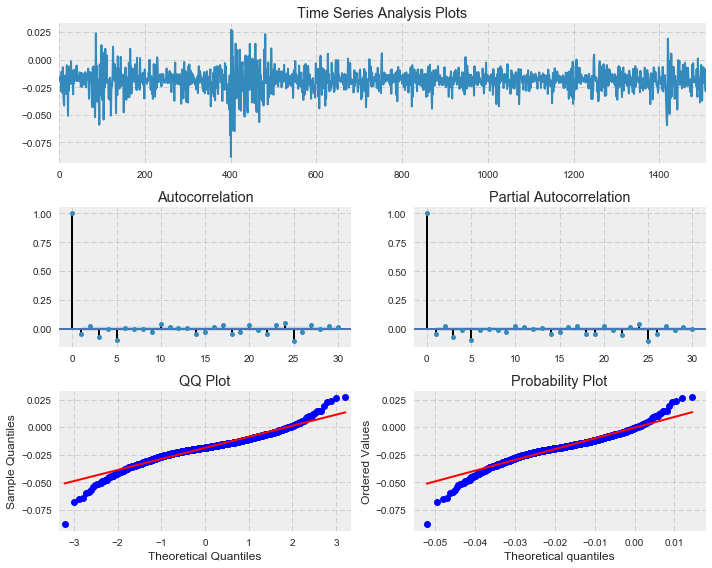

In [60]:
tsplot(res.resid, 30)

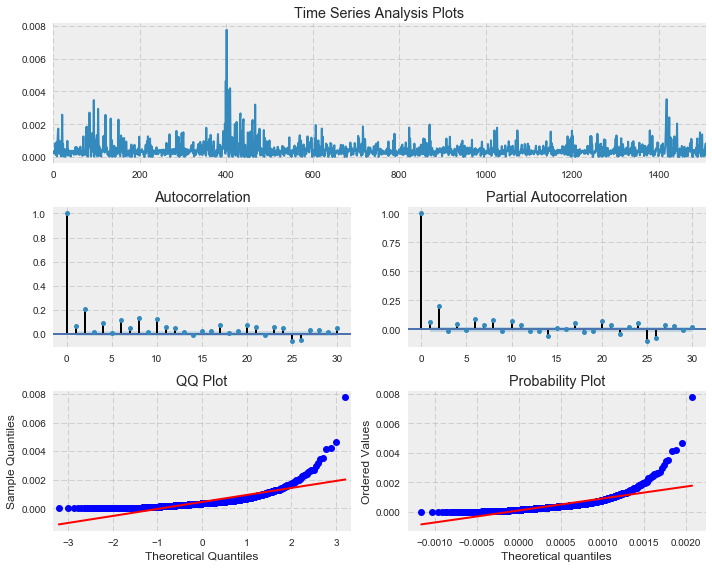

In [61]:
tsplot(np.square(res.resid), 30)

Looks like much better fit!